<a href="https://colab.research.google.com/github/Pradeepjha88/Logistic-regression/blob/main/S07a_multiple_hidden_layer_binary_output_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 07a

## Multiple Hidden Layers Binary output
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

## Story so far
    
    
|#|Sheet #|Dataset|Implementation|Training Accuracy|Testing Accuracy|Remarks|
|:-:|:-:|:-:|:--|---|---|:--|
|1|S04a|make_moons|Simple Perceptron|0.84111|0.89000||
|2|S04b|make_moons|Perceptron including Softmax and Gradient Descent|0.86555|0.90000|Training Accuracy catching up|
|3|S06a|make_moons|One hidden layer with ${Tanh}$ activation|0.96875|0.960938| Better, non-linearity helps|
|4|S06b|make_moons|One hidden layer with ${ReLU}$ activation|0.96387|0.96875| Still better, Taking little longer to converge|
|5|S06c|make_moons|One hidden layer with ${Swish}$ activation|0.96680|0.96094| Similar results, Taking even longer to converge|
|6|S06d|make_circles|One hidden layer with ${Tanh}$ activation|0.83643|0.82715| Different dataset|
|7|S06e|make_circles|One hidden layer with ${ReLU}$ activation|0.83130|0.82910| Better than $Tanh$|
|8|S06f|make_circles|One hidden layer with ${Swish}$ activation|0.83471|0.83301| Better than other two|

In [ ]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10000 # number of cycles to run
ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg
plt.rcParams.update(params) # update rcParams

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;color:black;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [ ]:
X, y = datasets.make_moons(n_samples=1280, shuffle=True, noise=0.2, random_state=RANDOM_STATE)

In [ ]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['Target'] = y
#data_df.head()

#data_df.describe()

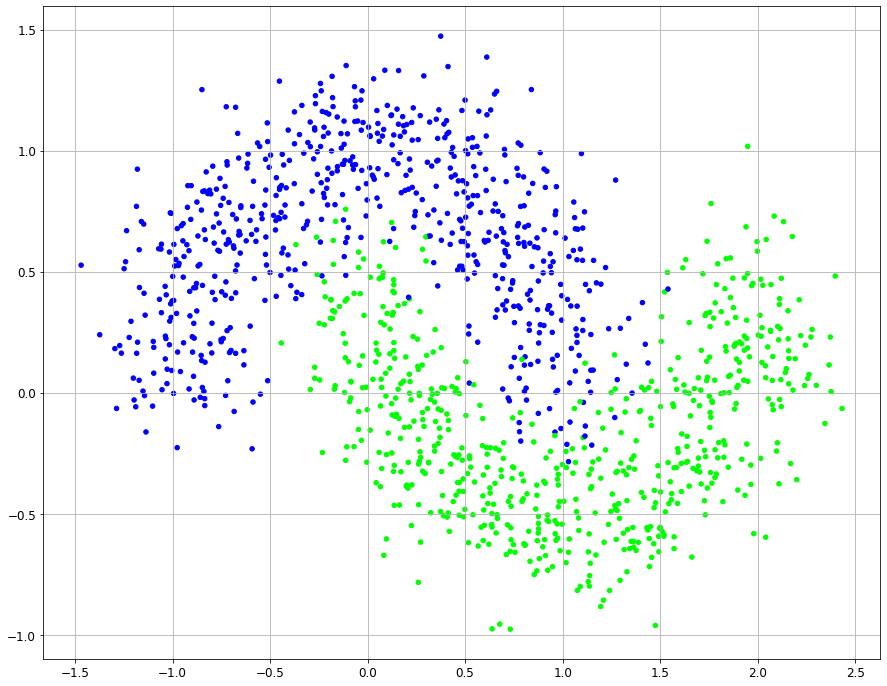

In [ ]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

In [ ]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X : feature matrix
           y : targets
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=CMAP, edgecolors='black')

In [ ]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


# Neural Network


## Recap
<img src='images/dnn_s07_fig1.png' style='width: 800px' />


## Forward Propagation
<div style="font-family: Arial; font-size:1.2em;color:black;">

<img src='images/dnn_s07_fig2.png' style='width: 800px;'/>

$
\begin{aligned}
Z^{[1]} & = X . W^{[1]} + b^{[1]} \\
a^{[1]} & = \text{g}(z^{[1]}) \\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;color:black;">
    Similarly for second layer.
</p>

$
\begin{aligned}
z^{[2]} & = a^{[1]}. W^{[2]} + b^{[2]} \\
a^{[2]} & = \hat{y} = \mathrm{softmax}(z^{[2]})\\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;color:black;">
    Where:
</p>
$
\begin{aligned}
\mathrm{softmax}(z_i) & =  \frac{e^{z_i}}{\sum\limits_{i = 1}^{L} {e^{z_i}}}\\
\end{aligned}
$
    <p style="font-family: Arial; font-size:1.2em;color:black;">
    Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
        $\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i}- max\left ( z \right )}}$
</p>
    </div>
    

## Softmax Function for output layer

In [ ]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Activation Function for other layers

In [ ]:
def fn_tanh(z):
    '''
    Args:
        z: array
    Returns:
        z: array
    '''
    return np.tanh(z)

def fn_tanh_prime(a):
    '''
    Args:
        a: array
    Returns:
        a: array
    '''
        
    return (1 - np.power(a, 2))

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;color:black;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;color:black;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

<img src='images/dnn_s07_fig3.png' style='width: 800px'/>

## Loss Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
The loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:
</p>
$$
\begin{aligned}
L(\hat{y},y) =  -y.log\hat{y} - (1-y) . log(1-\hat{y})
\end{aligned}
$$
<p style="font-family: Arial; font-size:1.2em;color:black;">
For all samples:
</p>
$$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum\limits_{i = 1}^{m} y_i.log\hat{y_i} - (1-y_i) . log(1-\hat{y_i})
\end{aligned}
$$

In [ ]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X.dot(W1) + b1 
    a1 = fn_tanh(z1)    # tanh activation

    # Layer 2
    z2 = a1.dot(W2) + b2 
    a2 = fn_tanh(z2)    # tanh activation

    # Layer 3
    z3 = a2.dot(W3) + b3 
    a3 = fn_tanh(z3)    # tanh activation
   
    # Layer 4
    z4 = a3.dot(W4) + b4 
    a4 = fn_tanh(z4)    # tanh activation
   
    # Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)   # softmax activation
    #***********************************
    
    ############################
    ### Calculating the loss ###
    ############################
    # Cross entropy = -ground truth x log (predicted)
    # probability of y being correct is 1. hence it will be a vector of [1,1,...,1,1]
    correct_logprobs = -np.log(a5[np.arange(num_examples), y]) # simplest way to pick a values
    data_loss = np.sum(correct_logprobs)
    
    
    return 1./num_examples * data_loss

## Forward Propogation

<img src='images/dnn_s07_fig4.png' style='width: 800px' alt = 'Session 6 Figure 4'/>
<br>
                                                               
$
\begin{aligned}
z^{[l]} & = a^{[l-1]} . W^{[l]} + b^{[l]}\\
a^{[l]} & = \text{g}(z^{[l]})\text{ for hidden layers} \\
a^{[l]} & = \mathrm{softmax}(z^{[l]})\text{ for output layer}  \\
\end{aligned}
$

## Predict Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [ ]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model : Dictionary object containing Weights and Biases
         X: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X.dot(W1) + b1 
    a1 = fn_tanh(z1)    # tanh activation
    
    # Layer 2
    z2 = a1.dot(W2) + b2 
    a2 = fn_tanh(z2)    # tanh activation
    
    # Layer 3
    z3 = a2.dot(W3) + b3 
    a3 = fn_tanh(z3)    # tanh activation
    
    # Layer 4
    z4 = a3.dot(W4) + b4 
    a4 = fn_tanh(z4)    # tanh activation
    
    # Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)# use softmax  
    return np.argmax(a5, axis=1) # pick with one with highest probabilities

<div style="font-family: Arial; font-size:1.2em;color:black;">
    We can use <b>$gradient$ $descent$</b> to find its minimum. For the purpose of this exercise, we will use <b>$batch$ $gradient$ $descent$</b> with a fixed learning rate. 
<br><br>
As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_l}}(= \partial{W^{[l]}})$, $\frac{\partial{L}}{\partial{b_l}}(= \partial{b^{[l]}})$, etc. To calculate these gradients we use the <b>back-propagation algorithm</b>, which is a way to efficiently calculate the gradients starting from the output.
    </div>

## Backpropogation
<hr>
<p style="font-family: Arial; font-size:1.2em;color:black;">
    For last layer.</p>
$
\begin{aligned}
\partial{z^{[L]}}  & = a^{[L]} - y \\
\partial{W^{[L]}}  & = \frac{1}{m} a^{[L-1]T}\circ \partial{z^{[L]}} \\
\partial{b^{[L]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[L]}}, axis = 0, keepdims = True) \\
\end{aligned}
$
<hr>
<p style="font-family: Arial; font-size:1.2em;color:black;">
    For any other layer</p>
$
\begin{aligned}
\partial{a^{[l]}}  & = \partial{z^{[l+1]}} . \partial{W^{[l+1]T}}\\
\partial{z^{[l]}}  & = \partial{a^{[l]}} * ( 1-a^{[l]}**2)\\
\partial{W^{[l]}}  & = \frac{1}{m} a^{[l-1]T}\circ \partial{z^{[l]}} \\
\partial{b^{[l]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[l]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

In [ ]:
# prepare the Model

def build_model(param, X, y, epochs=2000, alpha = 0.1, print_loss=False):
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Features to train on
        y : Targets to train on
        epochs : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every 1000 iterations
    return:
        model: a dict with weights and biases
        probs: probabilities
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE)
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))

    # Store model parameters in a dict to return in the end
    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    curr_loss = 0
    epoch = []
    loss = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):

        #############################
        ###  Forward propagation  ###
        #############################

        # Layer 1
        z1 = X.dot(W1) + b1 
        a1 = fn_tanh(z1)    # tanh activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2 
        a2 = fn_tanh(z2)    # tanh activation
        
        # Layer 3
        z3 = a2.dot(W3) + b3 
        a3 = fn_tanh(z3)    # tanh activation
        
        # Layer 4
        z4 = a3.dot(W4) + b4 
        a4 = fn_tanh(z4)    # tanh activation
        
        # Layer 5
        z5 = a4.dot(W5) + b5
        a5 = fn_softmax(z5) # softmax for final layer as it is binary classification
        
        #########################
        #### Backpropagation #### 
        #########################
        
        # Layer 5 **********************************
        dz5 = a5
        dz5[np.arange(num_examples), y] -= 1 # dL/db = dL/dz = (a-y). 
        #  As Y is single dimension subtract one from its class
        
        dW5 = (a4.T).dot(dz5) 
        db5 = np.sum(dz5, axis=0, keepdims=True) # db5 is vertical sum of dz5
        da4 = dz5.dot(W5.T)
        assert (dW5.shape == W5.shape),"Shape of dW5 {} and W5 {} do not match".format(dW5.shape, W5.shape)
        assert (da4.shape == a4.shape),"Shape of da4 {} and a4 {} do not match".format(da4.shape, a4.shape)
        
        # Layer 4 **********************************
        dz4 = da4 * fn_tanh_prime(a4)        
        dW4 = (a3.T).dot(dz4)        
        db4 = np.sum(dz4, axis=0, keepdims=True)
        da3= dz4.dot(W4.T)
        assert (dz4.shape == z4.shape),"Shape of dz4 {} and z4{} do not match".format(dz4.shape, z4.shape)
        assert (dW4.shape == W4.shape),"Shape of dW4 {} and W4 {} do not match".format(dW4.shape, W4.shape)
        assert (da3.shape == a3.shape),"Shape of da3 {} and a3 {} do not match".format(da3.shape, a3.shape)

        # Layer 3 **********************************
        dz3 = da3 * fn_tanh_prime(a3)
        dW3 = (a2.T).dot(dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2= dz3.dot(W3.T)
        assert (dz3.shape == z3.shape),"Shape of dz3 {} and z3{} do not match".format(dz3.shape, z3.shape)        
        assert (dW3.shape == W3.shape),"Shape of dW3 {} and W3 {} do not match".format(dW3.shape, W3.shape)
        assert (da2.shape == a2.shape),"Shape of da2 {} and a2 {} do not match".format(da2.shape, a2.shape)

        # Layer 2 **********************************
        dz2 = da2 * fn_tanh_prime(a2)        
        dW2 = (a1.T).dot(dz2)        
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1= dz2.dot(W2.T)
        assert (dz2.shape == z2.shape),"Shape of dz2 {} and z2{} do not match".format(dz2.shape, z2.shape)
        assert (dW2.shape == W2.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        assert (da1.shape == a1.shape),"Shape of da1 {} and a1 {} do not match".format(da1.shape, a1.shape)

        # Layer 1 **********************************
        dz1 = da1 * fn_tanh_prime(a1)
        dW1 = (X.T).dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert (dz1.shape == z1.shape),"Shape of dz1 {} and z1{} do not match".format(dz1.shape, z1.shape)        
        assert (dW1.shape == W1.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)        
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)
        #dA0= dZ1.dot(W1.T)
        #assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)


        # Gradient descent parameter update
        W1 += -alpha * dW1 / num_examples
        b1 += -alpha * db1 / num_examples
     
        W2 += -alpha * dW2 / num_examples
        b2 += -alpha * db2 / num_examples
        
        W3 += -alpha * dW3 / num_examples
        b3 += -alpha * db3 / num_examples
        
        W4 += -alpha * dW4 / num_examples
        b4 += -alpha * db4 / num_examples
        
        W5 += -alpha * dW5 / num_examples
        b5 += -alpha * db5 / num_examples
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5,}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:            
            print("Loss after iteration %i: %f" %(i, curr_loss))

            
    curr_loss = calculate_loss(model, X, y)
    print("Loss after iteration %i: %f" %(i, curr_loss))
    epoch.append(i)
    loss.append(curr_loss)
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [ ]:
# define nodes in each of dims
layer_param = {}
layer_param['nn_hdim'] = [2,5,5,4,3]
loss_hist = {}

In [ ]:
num_examples = len(X_train) # training set size
#nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
alpha = ALPHA # learning rate for gradient descent

epochs = EPOCHS

# Build a model with layes as per layer_param
model = build_model(layer_param, X_train, y_train, epochs, alpha, print_loss=True)

Loss after iteration 0: 0.000000
Loss after iteration 1000: 0.078170
Loss after iteration 2000: 0.074357
Loss after iteration 3000: 0.072472
Loss after iteration 4000: 0.071083
Loss after iteration 5000: 0.069941
Loss after iteration 6000: 0.068975
Loss after iteration 7000: 0.068164
Loss after iteration 8000: 0.067481
Loss after iteration 9000: 0.066881
Loss after iteration 9999: 0.066312


In [ ]:
model

{'W1': array([[ 1.51273392, -0.83167476, -0.71798987, -2.05821116, -0.76876635],
        [-1.6688401 ,  0.40296353,  0.26551134, -1.08565307,  0.0807578 ]]),
 'b1': array([[ 0.41579416,  0.34301077,  0.71501317,  1.09397861, -0.01920272]]),
 'W2': array([[ 0.35481179,  0.60800707, -0.7790916 , -0.05496271, -0.34017269],
        [ 0.06778738,  1.14966502,  0.75560094, -0.32715568,  0.27286631],
        [-0.91843003,  0.70743985,  0.91251808, -0.45279134,  0.05739417],
        [ 0.69789517, -0.79747546,  0.97912475,  0.62443519,  0.24194104],
        [-0.39116229,  0.62873299,  1.02849925, -0.89700496,  0.72113783]]),
 'b2': array([[-1.24545536e-01, -1.13953694e-04,  5.34780208e-01,
         -1.16595054e-01, -3.71328123e-01]]),
 'W3': array([[-1.14722101, -0.27674905,  0.52517571,  0.13205137],
        [ 0.27936433,  0.73911942, -0.16203231, -1.22250492],
        [ 0.19526405,  0.63427421,  0.52276422,  1.2195254 ],
        [-0.11647239, -0.93888663,  0.0691285 ,  1.02114499],
        [ 

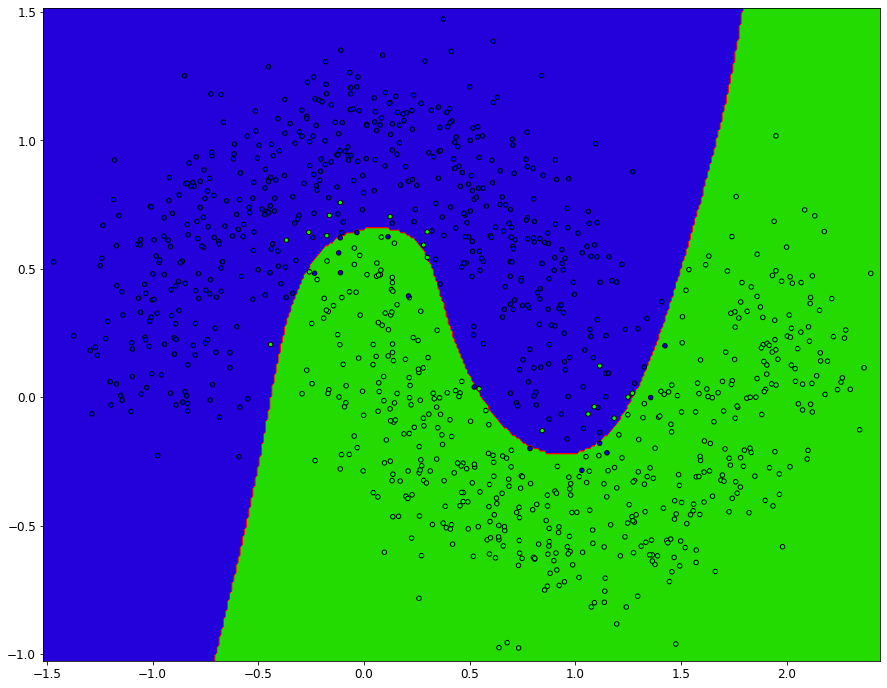

In [ ]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [ ]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(y_train, y_pred))

Accruacy score on Train Data : 0.96875


In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test, y_pred))

Accruacy score on Test Data : 0.9609375


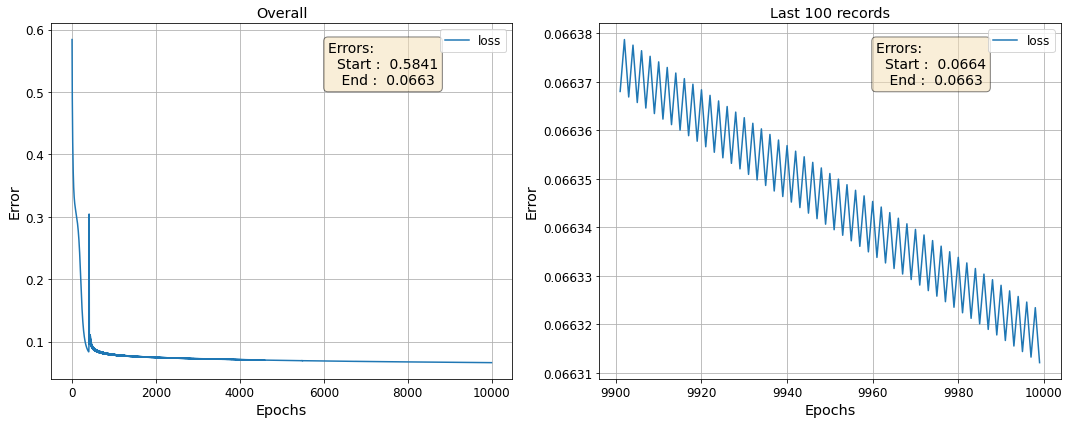

In [ ]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

# Tracking 
<div style="font-family: Arial; font-size:1.2em;color:black;">
    Lets track the results across various implementations... 
    </div>
    
    
|#|Sheet #|Dataset|Implementation|Training Accuracy|Testing Accuracy|Remarks|
|:-:|:-:|:-:|:--|---|---|:--|
|1|S04a|make_moons|Simple Perceptron|0.84111|0.89000||
|2|S04b|make_moons|Perceptron including Softmax and Gradient Descent|0.86555|0.90000|Training Accuracy catching up|
|3|S06a|make_moons|One hidden layer with ${Tanh}$ activation|0.96875|0.96094| Better, non-linearity helps|
|4|S06b|make_moons|One hidden layer with ${ReLU}$ activation|0.96387|0.96875| Still better, Taking little longer to converge|
|5|S06c|make_moons|One hidden layer with ${Swish}$ activation|0.96680|0.96094| Similar results, Taking even longer to converge|
|6|S06d|make_circles|One hidden layer with ${Tanh}$ activation|0.83643|0.82715| Different dataset|
|7|S06e|make_circles|One hidden layer with ${ReLU}$ activation|0.83130|0.82910| Better than $Tanh$|
|8|S06f|make_circles|One hidden layer with ${Swish}$ activation|0.83471|0.83301| Better than other two|
|9|S07a|make_moons|Multiple Hidden Layers|0.96875|0.96094|Similar results.|


## Assignment: S07-01
<div style="font-family: Arial; font-size:1.2em;color:black;">
    <ul>
<li>Using number of epoch 5000, 10000, 15,000, 20,000 and so on, print Training and Test accuracies.</li>
        <li>Comment on your results.</li>
    </ul>
</div>

|#|Number of Epochs|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:--|
|1|5000|...|...|...|
|2|10000|...|...|...|
|3|15000|...|...|...|
|4|20000|0.974609375|0.95703125|????|
|...|...|...|...|...|...|